In [1]:
import numpy as np

import datagenerator
import warnings
import os
warnings.filterwarnings('ignore')

import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from librosa.core.spectrum import  util

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader
import os

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils, datasets

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cpu')

In [3]:
batch_size = 512
mfcc_hop = 512
mfcc_frame = 2048
n_mfcc = 15
sr = 16000
n_win = 18
n_hop = 1
files = np.array(os.listdir('../data_denis'))

In [141]:
def frame_to_sec(x):
    return ((x-1)*mfcc_hop + mfcc_frame)/sr

# Импорт данных

In [4]:
dg = datagenerator.DataGenerator(n_hop,n_win,sr)
features = np.zeros([0,n_win,n_mfcc])
target = np.zeros([0])
sscaler = StandardScaler()
for name in files[:-1]:
    mfccs = datagenerator._from_denis('../data_denis/'+name)
    mfccs = sscaler.fit_transform(mfccs)
    mfccs_frame = util.frame(mfccs, frame_length=n_win, hop_length=n_hop, axis =0)
    features = np.append(features,mfccs_frame, axis=0)
    target = np.append(target, dg._get_target('../data/marks/'+name[:-4]+'__mark.txt', mfccs_frame.shape[0]*mfcc_hop+(n_win+2)*mfcc_hop))
    print(name, target.shape[0]== features.shape[0], features.shape, target.shape)
features_f = np.array([x.flatten() for x in features])
new_target = np.array([[x==0, x==1] for x in target])

chips.txt True (1944, 18, 15) (1944,)
clear.TXT True (3894, 18, 15) (3894,)
clear_1.txt True (4817, 18, 15) (4817,)
fast.txt True (6748, 18, 15) (6748,)
music.txt True (10409, 18, 15) (10409,)
speak.txt True (12993, 18, 15) (12993,)


In [5]:
test = np.zeros([0,n_win,n_mfcc])
target_test = np.zeros([0])
for name in files[-1:]:
    print(name)
    mfccs = datagenerator._from_denis('../data_denis/'+name)
    mfccs = sscaler.transform(mfccs)
    mfccs_frame = util.frame(mfccs, frame_length=n_win, hop_length=n_hop, axis =0)
    test = np.append(test,mfccs_frame, axis=0)
    target_test = np.append(target_test, dg._get_target('../data/marks/'+name[:-4]+'__mark.txt', mfccs_frame.shape[0]*mfcc_hop+(n_win+2)*mfcc_hop))
test_f = np.array([x.flatten() for x in test])
new_target_test = np.array([[x==0, x==1] for x in target_test])

sport.txt


In [181]:
from joblib import dump, load
dump(sscaler, 'std_scaler.bin', compress=True)

['std_scaler.bin']

# Создание dataloaders

In [6]:
X_train_t = torch.FloatTensor(features)[:,None,:,:]
y_train_t =  torch.Tensor(target).type(torch.LongTensor)
X_val_t =  torch.FloatTensor(test)[:,None,:,:]
y_val_t =  torch.Tensor(target_test).type(torch.LongTensor)

In [7]:
X_train_t.shape, y_train_t[0]

(torch.Size([12993, 1, 18, 15]), tensor(0))

In [8]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Код обучения

In [29]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    train_losses = []
    val_losses = []
    valid_accuracies = []
    train_accuracies = []
    best_acc = 0
    for epoch in range(epochs):
        model.train()
        loss_sum = 0
        correct = 0
        num = 0
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)

            probs = model(xb)
            loss = loss_func(probs, yb)
            loss_sum += loss.item()

            loss.backward()
            opt.step()
            opt.zero_grad()

            _, preds = torch.max(probs, axis=-1)
            correct += (preds == yb).sum().item()
            num += len(xb)

        train_losses.append(loss_sum / len(train_dl))
        train_accuracies.append(correct / num)

        model.eval()
        loss_sum = 0
        correct = 0
        num = 0
        with torch.no_grad():
            for xb, yb in valid_dl:
                xb, yb = xb.to(device), yb.to(device)

                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()

                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
        epoch_acc = correct / num

        if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(epoch_acc)
    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, valid_accuracies, train_accuracies

## Функция для отрисовки

In [23]:
import seaborn as sb

def plot_trainig(train_losses, valid_losses, valid_accuracies, train_accuracies):
    sb.set(style = "darkgrid", font_scale=1.4)
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.plot(train_accuracies, label="train accuracy")
    plt.legend()

In [52]:
from sklearn.metrics import classification_report
def model_test(model, valid_dataloader):
    model.eval()
    prediction = np.array([])
    with torch.no_grad():
        for xb, yb in valid_dataloader:
            xb, yb = xb.to(device), yb.to(device)

            probs = model(xb)

            _, preds = torch.max(probs, axis=-1)
            prediction = np.append(prediction, preds.numpy())
    print(classification_report(target_test, prediction))
    print("prediction:")
    print(np.sum([prediction[i]!=prediction[i+1] for i in range(prediction.shape[0]-1)])/2)
    print(prediction.sum())
    print("target:")
    print(np.sum([target_test[i]!=target_test[i+1] for i in range(target_test.shape[0]-1)])/2)
    print(target_test.sum())
    return prediction

# Обучение

In [11]:
import torch.nn.functional as F 

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.fc1 = nn.Linear(20 * 12 * 9, 120)  # !!!
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 20 * 12 * 9)  # !!!
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [44]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

loaders = {"train": train_dataloader, "valid": valid_dataloader}



In [25]:
batch = []

batch = next(iter(train_dataloader))

model.forward(torch.FloatTensor(batch[0])).shape, batch[0].shape

(torch.Size([512, 2]), torch.Size([512, 1, 18, 15]))

# Анализ

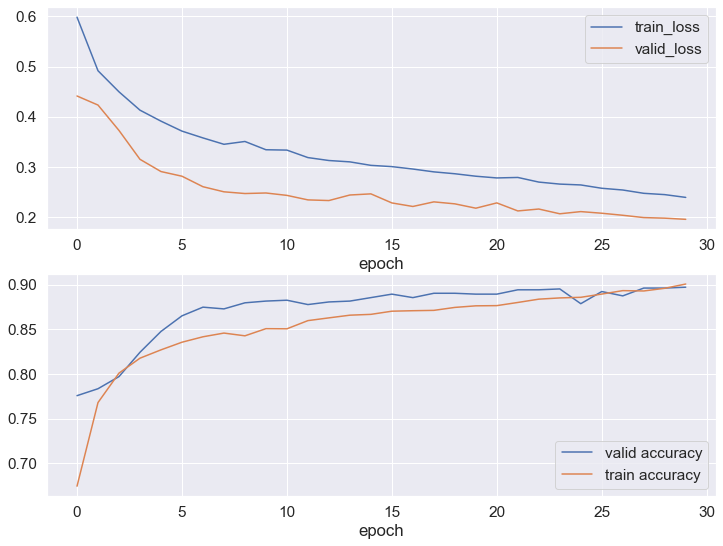

In [45]:
model, train_losses, val_losses, valid_accuracies, train_accuracies = fit(30, model, criterion, optimizer, train_dataloader, valid_dataloader)
plot_trainig(train_losses, val_losses, valid_accuracies, train_accuracies)

In [50]:
model_test(model, valid_dataloader)

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       646
         1.0       0.85      0.88      0.86       384

    accuracy                           0.90      1030
   macro avg       0.89      0.89      0.89      1030
weighted avg       0.90      0.90      0.90      1030

prediction:
102
394.0
target:
96
384.0


array([1., 1., 1., ..., 0., 0., 1.])

## Dropout

In [16]:
class ModelDropout(nn.Module):
    def __init__(self):
        super(ModelDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3)
        self.fc1 = nn.Linear(20 * 12 * 9, 120)  # !!!
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = x.view(-1, 20 * 12 * 9)  # !!!
        x = self.dropout1(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

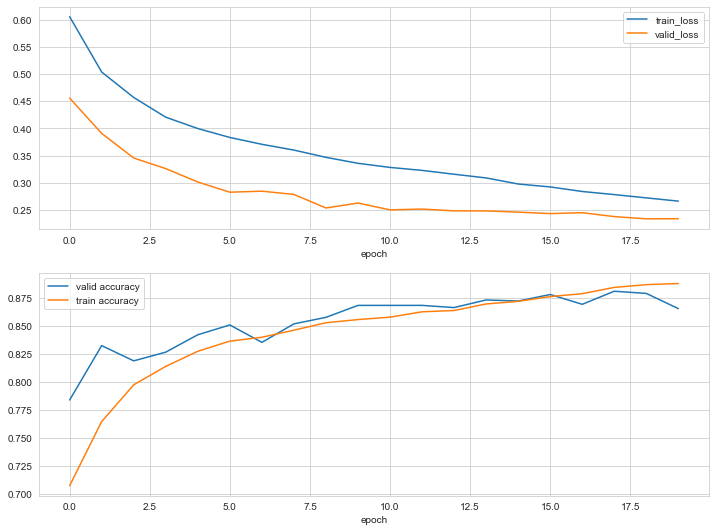

In [17]:
model = ModelDropout().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

info = fit(20, model, criterion, optimizer, train_dataloader, valid_dataloader)
plot_trainig(*info)

In [78]:
prediction = model_test(model, valid_dataloader)

              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       646
         1.0       0.85      0.88      0.86       384

    accuracy                           0.90      1030
   macro avg       0.89      0.89      0.89      1030
weighted avg       0.90      0.90      0.90      1030

prediction:
51.0
394.0
target:
48.0
384.0


In [75]:
torch.save(model.state_dict(), 'Net_181121.pth')

In [77]:
model.load_state_dict(torch.load('Net_181121.pth'))

<All keys matched successfully>

# AlexNet

# Детектирование

In [57]:
np.sum([prediction[i]!=prediction[i+1] for i in range(prediction.shape[0]-1)]), np.sum([target_test[i]!=target_test[i+1] for i in range(target_test.shape[0]-1)])

(102, 96)

In [58]:
prediction.sum(), target_test.sum()

(394.0, 384.0)

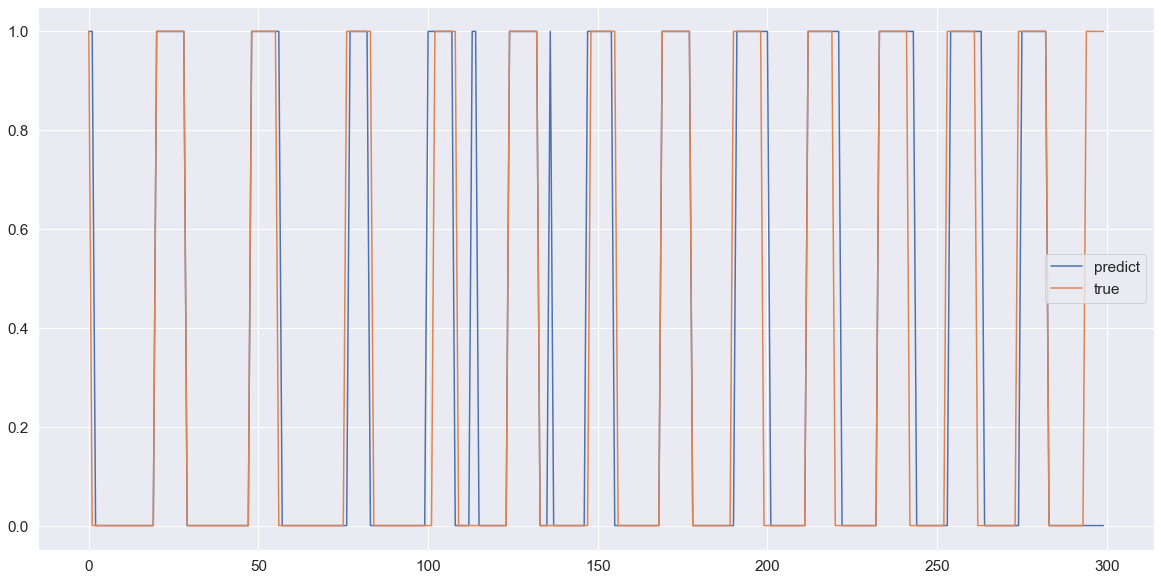

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,10])
plt.plot(prediction[200:500], label="predict")
plt.plot(target_test[200:500], label ="true")
plt.legend()

In [59]:
def frame_analyse(marks):
    hbflag = False
    hb_start = []
    hb_end = []
    for k,mark in enumerate(marks):
        if mark:
            if hbflag==False:
                hb_start.append(k)
            hbflag = True
        elif hbflag:
            hb_end.append(k)
            hbflag = False
    if hbflag:
            hb_end.append(k)
            hbflag = False
    return hb_start,hb_end

In [157]:
starts, ends = frame_analyse(target_test)
frame_target = pd.DataFrame({"starts":starts,"ends":ends})

In [60]:
def func(prediction):
    starts, ends = frame_analyse(prediction)
    frame_pred = pd.DataFrame({"starts":starts,"ends":ends})
    frame_pred["duration"] = frame_pred["ends"]-frame_pred["starts"]
    frame_pred["durpcm"] = (frame_pred["duration"]-1)*mfcc_hop + mfcc_frame
    frame_pred["dursec"] = frame_pred["durpcm"]/sr
    return frame_pred

In [61]:
frame_target = func(target_test)
frame_pred = func(prediction)

In [172]:
trstart, trend = dg._get_start_end("../data\marks\sport__mark.txt")

In [193]:
frame_target["durtrue"] = trend - trstart
frame_target["durtruesec"] = frame_target["durtrue"]/sr
frame_target["raz"] = frame_target["durpcm"]-frame_target["durtrue"]

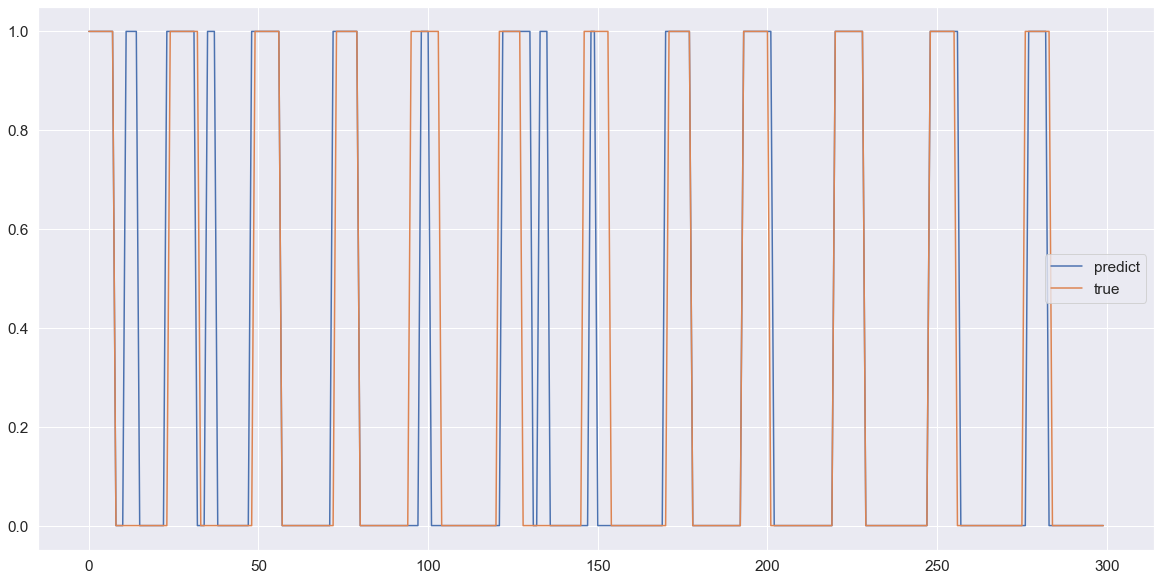

In [115]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,10])
plt.plot(prediction[0:300], label="predict")
plt.plot(target_test[0:300], label ="true")
plt.legend()

In [63]:
frame_pred.describe()

,starts,ends,duration,durpcm,dursec
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,496.442308,504.000000,7.557692,5405.538462,0.337846
std,311.170996,311.627291,2.515937,1288.159813,0.080510
min,0.000000,8.000000,0.000000,1536.000000,0.096000
25%,241.000000,250.000000,8.000000,5632.000000,0.352000
50%,493.500000,501.500000,8.000000,5632.000000,0.352000
75%,752.250000,762.500000,9.000000,6144.000000,0.384000
max,1029.000000,1029.000000,11.000000,7168.000000,0.448000


In [62]:
frame_target.describe()

,starts,ends,duration,durpcm,dursec
count,49.000000,49.000000,49.000000,49.000000,49.000000
mean,538.469388,546.285714,7.816327,5537.959184,0.346122
std,301.828808,301.573236,1.536683,786.781682,0.049174
min,0.000000,8.000000,0.000000,1536.000000,0.096000
25%,302.000000,309.000000,7.000000,5120.000000,0.320000
50%,551.000000,557.000000,8.000000,5632.000000,0.352000
75%,789.000000,796.000000,9.000000,6144.000000,0.384000
max,1029.000000,1029.000000,10.000000,6656.000000,0.416000


In [138]:
new_df = frame_pred[frame_pred["duration"]>4]

In [139]:
new_pred = np.zeros(prediction.shape[0])
for start, end in zip(new_df["starts"],new_df["ends"]):
    new_pred[start:end]+=1

In [121]:
print(classification_report(target_test,new_pred))

              precision    recall  f1-score   support

         0.0       0.92      0.93      0.92       646
         1.0       0.88      0.86      0.87       384

    accuracy                           0.90      1030
   macro avg       0.90      0.89      0.90      1030
weighted avg       0.90      0.90      0.90      1030



In [131]:
import matplotlib.pyplot as plt
def visual(new_pred, target_test,st=0, en=300):
    xc = np.arange(st, en)
    fig, ax1 = plt.subplots(1, 1, sharex=True,figsize=[30,10])
    #fig.figure(figsize=[20,10])
    print(classification_report(new_pred, target_test))
    ax1.fill_between(xc,0,new_pred[st:en], label="predict",alpha=0.8,facecolor='blue')
    ax1.fill_between(xc,0,target_test[st:en], label ="true",alpha=0.8,facecolor='red')
    ax1.fill_between(xc,0,target_test[st:en]*new_pred[st:en], label ="пересечение",alpha=1,facecolor='green')
    ax1.legend()
    plt.show()

              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       655
         1.0       0.86      0.88      0.87       375

    accuracy                           0.90      1030
   macro avg       0.89      0.90      0.90      1030
weighted avg       0.90      0.90      0.90      1030



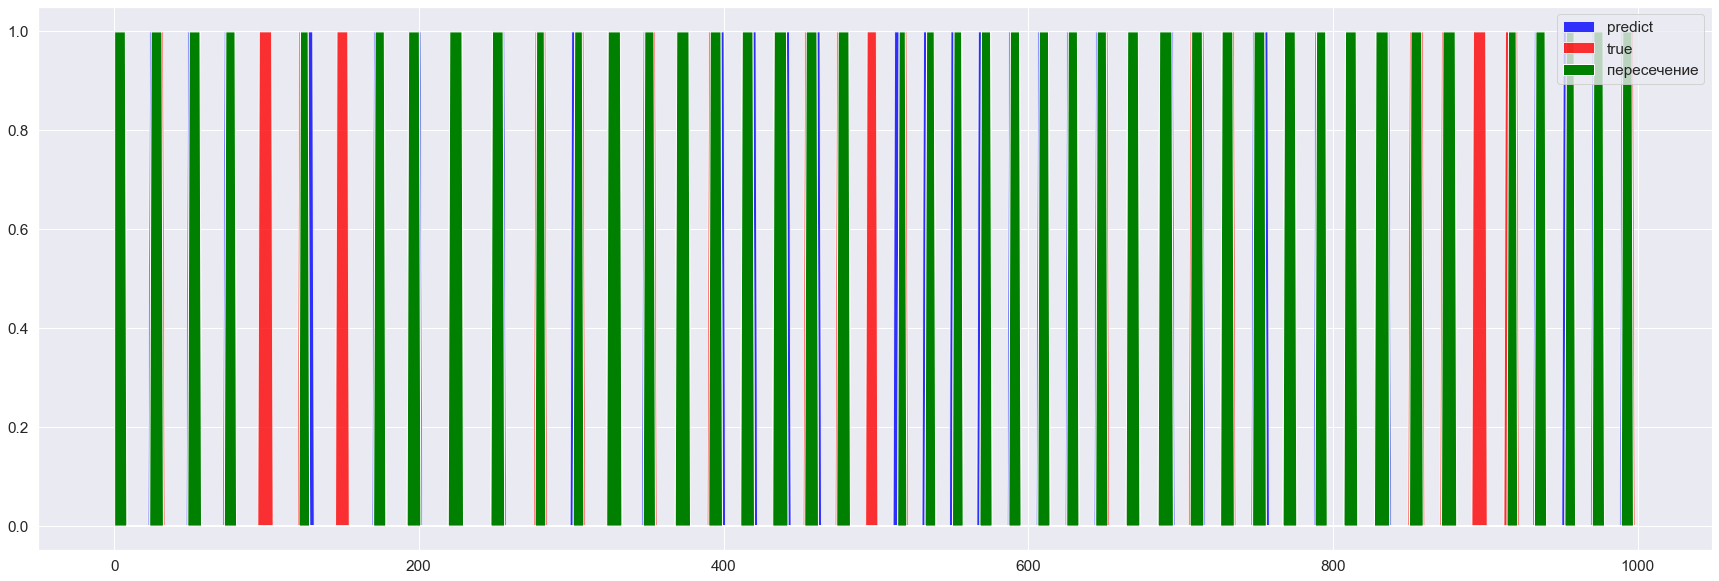

In [140]:
visual(new_pred,target_test,0,1000)

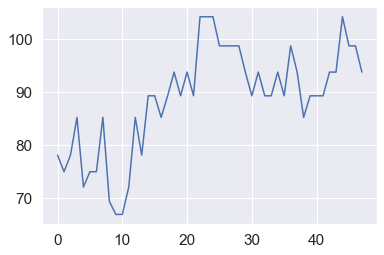

In [169]:
secst = frame_target["starts"].apply(frame_to_sec)
hr = [60/(secst[i]-secst[i-1]) for i in range(1,secst.shape[0])]
plt.plot(hr)

In [170]:
len(hr), frame_target["starts"][:-1].shape

(48, (47,))

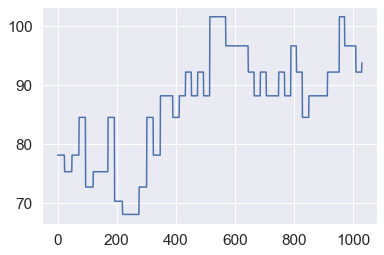

In [180]:
hb = np.zeros(prediction.shape[0])
last = None
for st, en, hh in zip(frame_target["starts"][:-1], frame_target["starts"][1:], hr):
    #print(st,en,hh)
    if last  == None:
        hb[st:en]+=hh
        last = hh
    else:
        hb[st:en]+=0.1*last +0.9*hh
hb[en:]+=hh
plt.plot(hb)

In [182]:
model

LeNet(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2160, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=2, bias=True)
)

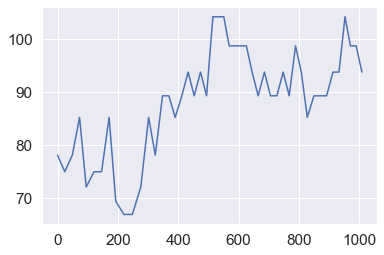

In [176]:
plt.plot(frame_target["starts"][:-1], hr)

In [116]:
frame_target[frame_target["duration"]>0].head(5)

,starts,ends,duration,durpcm,dursec
0,0,8,8,5632,0.352
1,24,33,9,6144,0.384
2,49,57,8,5632,0.352
3,73,80,7,5120,0.320
4,95,104,9,6144,0.384


In [117]:
new_df.head(5)

,starts,ends,duration,durpcm,dursec
0,0,8,8,5632,0.352
1,11,15,4,3584,0.224
2,23,32,9,6144,0.384
3,35,38,3,3072,0.192
4,48,57,9,6144,0.384
